### Correlations:

Correlation or dependence is any statistical relationship, whether causal or not. In the broadest sense, "correlation" may indicate any type of association.

Correlations are useful because they can indicate a predictive relationship that can be exploited in practice.

In [1]:
# libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as ss
import math
from collections import Counter
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from statsmodels.tsa.stattools import grangercausalitytests
import yfinance as yf

#pandas option to show all columns 
pd.set_option('display.max.columns', None)

#global figure size for matplotlib
plt.rcParams['figure.figsize'] = (18, 6)

# get data for non time series associations
df = pd.read_csv('dataset.csv')
print('(Rows, Columns): ',df.shape)
df.head(5)

/Users/adames/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


(Rows, Columns):  (1000, 11)


,Duration_in_months,Purpose,Credit_amount,Age_in_years,Job,Customer Balance,Loan Sanctioned Status,Loan Amount,Annual income,Customer Category,Target
0,6,A43,1169,67.0,A173,22876,Yes,192584,63890,B,1
1,48,A43,5951,22.0,A173,26204,Yes,275998,119895,C,2
2,12,A46,2096,49.0,A172,33814,No,0,13157,C,1
3,42,A42,7882,45.0,A173,20934,Yes,395792,130148,B,1
4,24,A40,4870,NaN,NaN,11109,Yes,156719,97403,C,2


### Correlations: Pearson

In general, this coefficient (Pearson) can be interpreted as follows:
- Magnitudes:
    - .00-.19 `very weak`
    - .20-.39 `weak`
    - .40-.59 `moderate`
    - .60-.79 `strong`
    - .80-1.0 `very strong`
- Sign:
    - positive indicate a proportional relationship
    - negative indicate a inverse proportional relationship

Pearson's correlation have some mathematical assumptions in order to be used properly. These can be summerized as:
 - variables must be continous
 - data must be linear
 - outliers affects the score

It is defined as:

 $$ Correlation = \frac{\sum{(X - X_{MEAN})*(Y - Y_{MEAN})}}{\sqrt{\sum{(X - X_{MEAN})^2}*\sum{(Y - Y_{MEAN})^2}}} $$

In [2]:
cor_matrix_tri = df.corr(method='pearson')
cor_matrix_tri.style.background_gradient(cmap='coolwarm')

/var/folders/qf/w2n_959j22x1qz6775lxlqsm0000gn/T/ipykernel_5991/2875549368.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor_matrix_tri = df.corr(method='pearson')


,Duration_in_months,Credit_amount,Age_in_years,Customer Balance,Loan Amount,Annual income,Target
Duration_in_months,1.000000,0.624984,-0.039069,-0.021713,-0.049132,-0.021488,0.214927
Credit_amount,0.624984,1.000000,0.029292,-0.014728,-0.000383,-0.025616,0.154739
Age_in_years,-0.039069,0.029292,1.000000,0.045744,-0.001517,-0.012241,-0.102952
Customer Balance,-0.021713,-0.014728,0.045744,1.000000,-0.001269,0.000366,-0.008011
Loan Amount,-0.049132,-0.000383,-0.001517,-0.001269,1.000000,0.783878,-0.082542
Annual income,-0.021488,-0.025616,-0.012241,0.000366,0.783878,1.000000,-0.055738
Target,0.214927,0.154739,-0.102952,-0.008011,-0.082542,-0.055738,1.000000


### Correlations: Spearman

- Spearman does not assumes linear relationship nor restricst ordinal variables. 
- It follows the same interpretation as the Pearson score

It is defined as:

 $$ Correlation = 1 - (\frac{(6*\sum{(X_{RANK} - Y_{RANK})^2})}{(N*(N^2-1))}) $$

where:
- N is the number of data points

In [3]:
cor_matrix_tri = df.corr(method='spearman')
cor_matrix_tri.style.background_gradient(cmap='coolwarm')

/var/folders/qf/w2n_959j22x1qz6775lxlqsm0000gn/T/ipykernel_5991/3441601897.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor_matrix_tri = df.corr(method='spearman')


,Duration_in_months,Credit_amount,Age_in_years,Customer Balance,Loan Amount,Annual income,Target
Duration_in_months,1.000000,0.624709,-0.035840,-0.023777,-0.038267,-0.015908,0.205685
Credit_amount,0.624709,1.000000,0.021392,-0.003477,0.003145,-0.005836,0.087083
Age_in_years,-0.035840,0.021392,1.000000,0.049694,0.011338,0.006674,-0.120439
Customer Balance,-0.023777,-0.003477,0.049694,1.000000,-0.003135,-0.001869,-0.007408
Loan Amount,-0.038267,0.003145,0.011338,-0.003135,1.000000,0.804072,-0.077293
Annual income,-0.015908,-0.005836,0.006674,-0.001869,0.804072,1.000000,-0.051808
Target,0.205685,0.087083,-0.120439,-0.007408,-0.077293,-0.051808,1.000000


### Correlation: Cramér’s V.

- Is a measure of association between two categorical features based on a nominal variation of Pearson’s Chi-Square Test.

- The output is in the range of [0,1], where 0 means no association and 1 is full association.

- The output matrix is also symmetrical, therofre asumes the same association for (x,y) and (y,x)

- Cramer’s V may lead to a loss of information due to the symmetry of it.

It is defined as:
 $$ Correlation = \sqrt{\frac{\chi^2}{(N*MIN(k,l))}} $$

where:
- $\chi^2$ is the chi-squared statistic
- N is the sample size
- k is the number of categories in the first variable
- l is the number of categories in the second variable.

In [4]:
def cramers_v(X:pd.Series, Y:pd.Series,rounding=2):
    x, y = X.copy(), Y.copy()
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return round(np.sqrt(phi2corr/min((kcorr-1),(rcorr-1))),rounding)

def categorical_correlation_matrix_C_V(df:pd.DataFrame):
    categorical_vars = list(df.select_dtypes(include = object).columns)
    row_var, col_var, correlation = [] , [] , []
    for i in categorical_vars:
        for j in categorical_vars:
            try:
                row_var.append(i) , col_var.append(j)
                correlation.append(cramers_v(X = df[i], Y = df[j]))
            except:
                row_var.append(i) , col_var.append(j)
                correlation.append(0)

    corr_matrix = pd.DataFrame({'Row var':row_var,'Col var':col_var,'Score':correlation})
    corr_matrix = pd.pivot(corr_matrix, index='Row var', columns='Col var', values='Score')
    corr_matrix.index.name , corr_matrix.T.index.name  = None , None
    return corr_matrix

cor_matrix_tri = categorical_correlation_matrix_C_V(df)
cor_matrix_tri.style.background_gradient(cmap='coolwarm')

,Customer Category,Job,Loan Sanctioned Status,Purpose
Customer Category,1.000000,0.000000,0.770000,0.000000
Job,0.000000,1.000000,0.000000,0.180000
Loan Sanctioned Status,0.770000,0.000000,1.000000,0.060000
Purpose,0.000000,0.180000,0.060000,1.000000


### Correlation: Theil’s U
- Theil’s U is a measure of the degree of inequality in a distribution.

- The output value is on the range of [0,1], with the same interpretations as before — but unlike Cramer’s V, it is asymmetric.

- It answers the following question:  given the value of x, how many possible states does y have, and how often do they occur?

- Using Theil’s U will let us find out that knowing y means we know x, but not vice-versa.

It is defined as:
$$ Correlation = \frac{(-\sum{P_{Xi}*LOG(P_{Xi})}) - (-\sum{P_{Yi}*LOG(P_{Yi})})}{LOG(N)} $$


where:
- $P_{Xi}$ and $P_{Yi}$ are the probability of each value in the distributions X and Y
- N is the number of values in the distribution.

In [5]:
def conditional_entropy(X:pd.Series,Y:pd.Series,log_base:float = math.e):
    x , y = X.copy(), Y.copy()
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y / p_xy, log_base)
    return entropy

def theils_u(X:pd.Series,Y:pd.Series,rounding=2):
    x , y = X.copy(), Y.copy()
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return round((s_x - s_xy) / s_x,rounding)

def categorical_correlation_matrix_th_u(df:pd.DataFrame):
    categorical_vars = list(df.select_dtypes(include = object).columns)
    row_var, col_var, correlation = [] , [] , []
    for i in categorical_vars:
        for j in categorical_vars:
            try:
                row_var.append(i) , col_var.append(j)
                correlation.append(theils_u(X = df[i], Y = df[j]))
            except:
                row_var.append(i) , col_var.append(j)
                correlation.append(0)

    corr_matrix = pd.DataFrame({'Row var':row_var,'Col var':col_var,'Score':correlation})
    corr_matrix = pd.pivot(corr_matrix, index='Row var', columns='Col var', values='Score')
    corr_matrix.index.name , corr_matrix.T.index.name  = None , None
    return corr_matrix

cor_matrix_tri = categorical_correlation_matrix_th_u(df)
cor_matrix_tri.style.background_gradient(cmap='coolwarm')

,Customer Category,Job,Loan Sanctioned Status,Purpose
Customer Category,1.000000,0.000000,0.310000,0.010000
Job,0.000000,1.000000,0.000000,0.060000
Loan Sanctioned Status,0.590000,0.000000,1.000000,0.010000
Purpose,0.010000,0.030000,0.000000,1.000000


### Correlation: Correlation Ratio

- The Correlation Ratio answers the following question: Given a continuous number, how well can you know to which category it belongs to? 

- Just like the two coefficients we’ve seen before, here too the output is on the range of [0,1].

It is defined as:
$$ Correlation = \frac{\sum_{X}{N_{X}*(\bar{Y}_{X} - \bar{Y})^2}}{\sum_{X,i}{(Y_{Xi} - \bar{Y})^2}} $$

where:
- $Y_{Xi}$ is each observation where X indicates the category that observation is in and i is the label of observation.

- $N_{X}$ is the number of observations in category X

- $\bar{Y}_{X}$ is the mean of the category X

- $\bar{Y}$ is the mean of the whole population

In [6]:
def correlation_ratio(categorical_var:pd.Series, numerical_var:pd.Series,rounding=2):
    categories , measurements = categorical_var.copy(), numerical_var.copy().astype(int)
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return round(eta,rounding)

def mixed_correlation_matrix(df:pd.DataFrame):
    categorical_vars = list(df.select_dtypes(include = object).columns)
    numerical_vars = list(df.select_dtypes(exclude = object).columns)
    row_var, col_var, correlation = [] , [] , []
    for i in categorical_vars:
        for j in numerical_vars:
            try:
                row_var.append(i) , col_var.append(j)
                correlation.append(correlation_ratio(categorical_var = df[i].values, numerical_var = df[j].values))
            except:
                row_var.append(i) , col_var.append(j)
                correlation.append(0)

    corr_matrix = pd.DataFrame({'Row var':row_var,'Col var':col_var,'Score':correlation})
    corr_matrix = pd.pivot(corr_matrix, index='Row var', columns='Col var', values='Score')
    corr_matrix.index.name , corr_matrix.T.index.name  = None , None
    return corr_matrix

cor_matrix_tri = mixed_correlation_matrix(df)
cor_matrix_tri.style.background_gradient(cmap='coolwarm')

,Age_in_years,Annual income,Credit_amount,Customer Balance,Duration_in_months,Loan Amount,Target
Customer Category,0.040000,0.710000,0.050000,0.030000,0.050000,0.660000,0.060000
Job,0.050000,0.040000,0.330000,0.070000,0.220000,0.040000,0.040000
Loan Sanctioned Status,0.010000,0.920000,0.010000,0.010000,0.020000,0.850000,0.060000
Purpose,0.050000,0.110000,0.370000,0.070000,0.270000,0.120000,0.180000


### Correlation: Time lagged cross correlation

- Time lagged cross correlation (TLCC) is a mathematical measure of similarity between two signals.

- This method holds one of the series in place, and creates both lags of the second series across the time period before computing the correlation coefficients. 

- For time series of the same length and no relative time delay, the definition is:

$$ Correlation_{XY}[0] = \sum_{n}{X[n]*Y[n]}$$

- For time series of different length and no relative time delay, the definition is:

$$ Correlation_{XY}[T] = \sum_{n}{X[n]*Y[n-T]}$$

where:
- $X[n]$ and $Y[n]$ are time series

- $n$ is the number of observations in the series

- $T$ is the time lag used to apply a relative time shift of the two sequences


If the p-value is > = your significance value, series x is not predictive of series y
 

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.3501  , p=0.8600  , df_denom=4, df_num=5
ssr based chi2 test:   chi2=6.5636  , p=0.2552  , df=5
likelihood ratio test: chi2=5.4443  , p=0.3641  , df=5
parameter F test:         F=0.3501  , p=0.8600  , df_denom=4, df_num=5
<built-in method values of dict object at 0x7fc5d9a2ec40>
 
####################################################
Close ^GSPC Is not stacionary
####################################################


/var/folders/qf/w2n_959j22x1qz6775lxlqsm0000gn/T/ipykernel_5991/531664856.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(df['Date'],rotation=90)


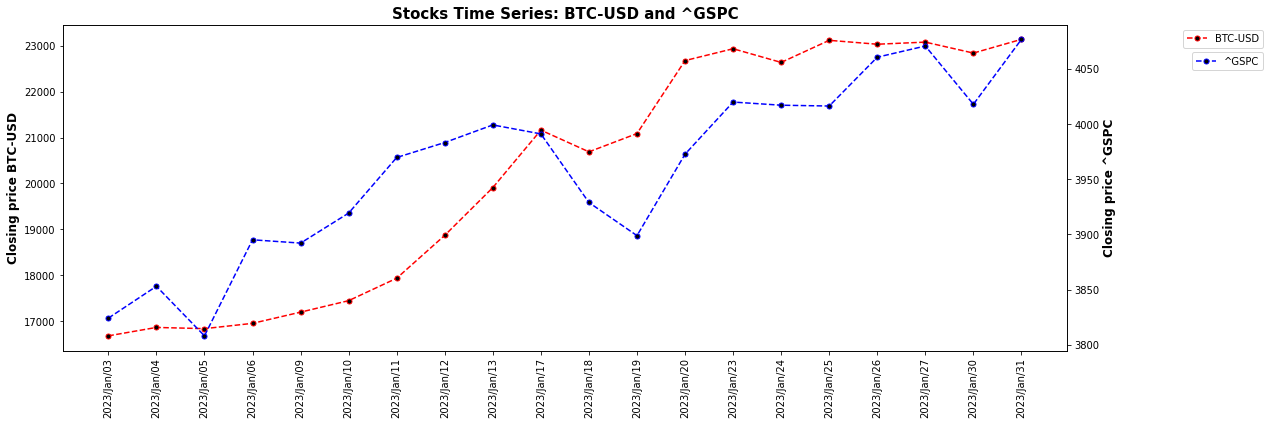

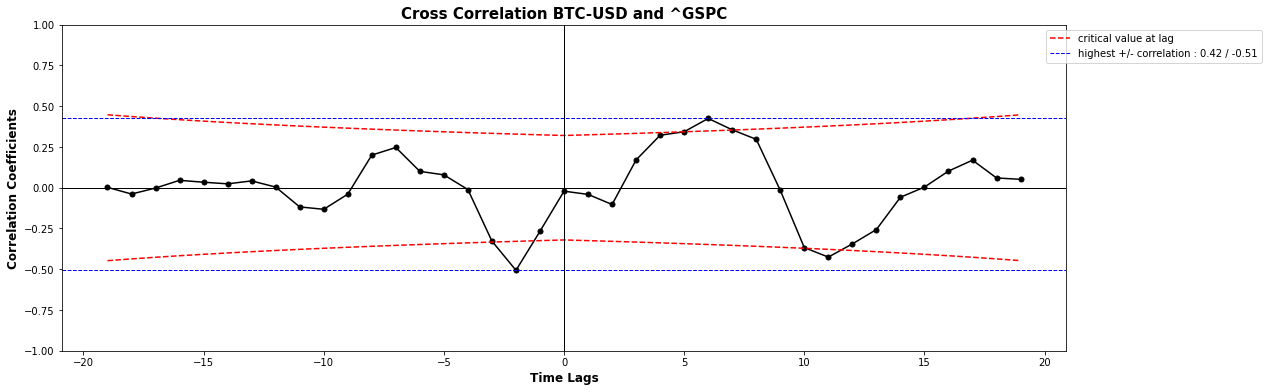

In [7]:
def two_stocks_relations(stock_x:str, stock_y:str, start_date:str , end_date:str, time_interval:str = '1d', 
                         result_date_format:str = '%Y/%b/%d', significance_value:float = 0.01, plots:bool = True, de_trend:bool = True):

    # stock data
    stock_x_df = yf.Ticker(stock_x).history(start = start_date, end = end_date, interval=time_interval)
    stock_y_df = yf.Ticker(stock_y).history(start = start_date, end = end_date, interval=time_interval)

    # inner merge
    merge_df = round(pd.merge(stock_x_df['Close'], stock_y_df['Close'],
                            left_index=True, right_index=True,
                            how = 'inner', suffixes=[' '+stock_x ,' '+stock_y]),2)

    #perform Granger-Causality test, if p val >= significance, then 
    print('If the p-value is > = your significance value, series x is not predictive of series y')
    print(' ')
    causality = grangercausalitytests(merge_df.loc[:,['Close '+stock_x,'Close '+stock_y]], maxlag=[5])
    print(causality.values)
    print(' ')
    
    
    # apply adf test
    adf_table = merge_df.apply(adf_test, axis = 0)
        
    # date time format
    merge_df = merge_df.reset_index()     
    merge_df['Date'] = pd.to_datetime(merge_df['Date'])
    merge_df['Date'] = merge_df['Date'].dt.strftime('%Y/%b/%d') 
    dates = merge_df['Date'].values 

    # stocks line plots
    title_label = 'Stocks Time Series: ' + stock_x + ' and ' + stock_y
    vis1 = two_stocks_plot(merge_df,stock_x =stock_x,stock_y = stock_y,label = title_label)

    # empty list
    not_stacionary = []

    # identify stacionary variables
    for var in adf_table.loc['P-value'].index:
        if round(adf_table.loc['P-value'][var],2) >= significance_value:
            print('####################################################')
            print(var + ' Is not stacionary')
            print('####################################################')
            not_stacionary.append(var)
    
    # de trend data if needed
    if de_trend == True:
        detrended_stock_x , detrended_stock_y = detrend(merge_df,stock_x,stock_y)

        merge_df = round(pd.merge(detrended_stock_x['Close '+stock_x],
                                                detrended_stock_y['Close '+stock_y],
                                                left_index=True, right_index=True,
                                                how = 'inner', suffixes=[' '+stock_x ,' '+stock_y]),2)
        merge_df.index = dates  
                                             
        # cross correlations
        c = time_lag_correlations(merge_df,stock_x,stock_y)

    else:
        # cross correlations
        c = time_lag_correlations(merge_df,stock_x,stock_y)

    # visuals
    if plots == True:        
        # correlations with lags
        lags = signal.correlation_lags(len(merge_df['Close '+stock_x]), len(merge_df['Close '+stock_y]))
        vis2 = time_lag_corr_plot(c,lags,stock_x = stock_x,stock_y = stock_y)

        #calling plot objects
        vis1
        vis2

    correlations_df = pd.DataFrame(c,
                                  index=[lags],
                                  columns = ['Correlations per lag'])

    return merge_df, correlations_df

def time_lag_corr_plot(corr,lags,stock_x,stock_y,significance_value = 0.01,size=(18, 6)):
    lag = lags
    n = len(corr)
    cutoff = critical_corr(samples_size = n ,lag = lag)
    cutoff_l = []
    for i in cutoff:
        cutoff_l.append(-1*i)

    fig, ax = plt.subplots(figsize = size)
    ax.plot(lags, corr,c='black', mfc='black',marker=".", ms=10)
    ax.plot(lags, cutoff,c='red',label = 'critical value at lag',mfc='black', linestyle='dashed', ms=10)
    ax.plot(lags, cutoff_l,c='red', mfc='black', linestyle='dashed', ms=10)
    ax.axvline(x = 0, color = 'black', lw = 1)
    ax.axhline(y = 0, color = 'black', lw = 1)
    ax.axhline(y = np.max(corr), color = 'blue',linestyle='dashed', lw = 1, label = 'highest +/- correlation : ' + str(round(np.max(corr),2)) + ' / ' + str(round(np.min(corr),2)))
    ax.axhline(y = np.min(corr), color = 'blue',linestyle='dashed', lw = 1)
    ax.set(ylim = [-1, 1])
    ax.set_title('Cross Correlation ' + stock_x + ' and ' + stock_y, weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', fontsize = 12)
    ax.set_xlabel('Time Lags', weight='bold', fontsize = 12)
    ax.legend(bbox_to_anchor=(1.2, 1))

def critical_corr(samples_size,lag): 
    crit_corr = []
    for i in range(0,samples_size):
        crit_corr.append( 2 / ( samples_size - np.abs(lag[i]) )**.5 )
    return crit_corr 

def two_stocks_plot(df, stock_x, stock_y, c='red', marker=".", size=(18, 6),
                      mfc='black', linestyle='dashed', ms=10, label = None):
                      
    fig, ax1 = plt.subplots(figsize =size)
    ax1.set_title(label, weight='bold', fontsize = 15)
    ax2 = ax1.twinx()

    ax1.plot(df['Date'], df['Close '+stock_x],
                        c=c,marker=marker,mfc=mfc,
                        linestyle=linestyle,ms=ms,label=stock_x)

    ax2.plot(df['Date'], df['Close '+stock_y],
                        c='blue',marker=marker,mfc=mfc,
                        linestyle=linestyle,ms=ms,label=stock_y)


    ax1.legend(bbox_to_anchor=(1.2, 1))
    ax2.legend(bbox_to_anchor=(1.2, 0.93))
    ax1.set_xticklabels(df['Date'],rotation=90)
    ax1.set_ylabel('Closing price '+stock_x, weight='bold', fontsize = 12)
    ax2.set_ylabel('Closing price '+stock_y, weight='bold', fontsize = 12);

def time_lag_correlations(df,stock_x,stock_y):
    p = df['Close '+stock_x]       
    q = df['Close '+stock_y]
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))  

    # cross correlations
    c = np.correlate(p, q, 'full')

    return c
  
def adf_test(_df, autolag='AIC'):
     # udf for adf test
    df_test = adfuller(_df, autolag=autolag)
    test_result = pd.Series(df_test[0:4],
                                index=['Test Statistic','P-value','Lags Used','No of Observations'])

    for key,value in df_test[4].items():
        test_result['Critical Value (%s)'%key] = value
        
    return test_result

def detrend(df,stock_x,stock_y):
    # de - trend time series x
    stock_x_df = signal.detrend(df['Close '+stock_x])
    detrended_stock_x = pd.DataFrame(stock_x_df,
                                    columns=['Close '+stock_x],
                                    index = df.index)
    # de - trend time series y
    stock_y_df = signal.detrend(df['Close '+stock_y])
    detrended_stock_y = pd.DataFrame(stock_y_df, 
                                    columns=['Close '+stock_y],
                                    index = df.index)

    return detrended_stock_x , detrended_stock_y

df,corrs = two_stocks_relations(stock_x = "BTC-USD" , # Bitcoin
                                stock_y = "^GSPC", # S&P 500 index
                                start_date = '2023-1-1', # initial date as january 1 2023
                                end_date = '2023-2-1', # last posible date as february 1 2023
                                plots = True, # plot stocks and correlations
                                de_trend = True) # auto adjust if time series not stacionary